# **`PyDEns`**:advanced usage

This tutorial continues with the examples of **`PyDEns`** usage and shows how to tackle harder problems, including equation systems, parameters and more. We strongly encourage you to take a look at [theory behind **`PyDEns`**](./0.%20Theory.ipynb) and [some examples](./1.%20Basic%20PDE%20solving.ipynb) before proceding to get a grip on the basics of our framework and math behind it.

This notebook works through following problems:
* [system of two equations in $\mathcal{R}$](#system)
* [parametric family of equations](#param)
* [equation with adjustable coefficients](#adjust)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Stop TF from showing unnecessary deprecation warnings
import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

sys.path.append('..') # this line is not needed if PyDEns is installed as package
from pydens import Solver, NumpySampler, cart_prod, add_tokens, plot_loss

<a id='tokens'></a>

In [2]:
add_tokens()

<a id='ex1'></a>

<a id='system'></a>

### System of two ODEs

With `PyDENs` it is also possible to solve system of equations. The basic semantics are the same, but `form`, `initial_condition`, `boundary_condition` are now lists of separate equations or conditions for each function respectively. You also have to provide additional information on equation by passing `n_funs` and `n_eqns` to PDE-configuration to communicate number of functions and number of equations of the problem.

Under the hood, each unknown function is approximated with a neural network: they have common `body` part and separate `head`'s. You can easily control, how much of the computational flow is shared between each approximator by adjusting `body`/`head` configs. 

\begin{cases}
u_1(t) + \dfrac{\partial u_2(t)}{ \partial t} = 0 \\
u_2(t) + \dfrac{\partial u_1(t)}{ \partial t} = 2 \cos(t)
\end{cases}

$$
u_1(0)=0, \quad u_2(0)=1.
$$

It is easy to see that $u_1(t) = \sin(t)$ and $u_2(t) = \cos(t)$ satisfy both system of equations and initial conditions.

In [3]:
pde = {'n_dims': 1, 'n_funs': 2, 'n_eqns': 2,
       'form': [lambda u0, u1, t: u0 + D(u1, t),
                lambda u0, u1, t: u1 + D(u0, t) - 2 * cos(t)],
       'initial_condition': [[0.0],
                             [1.0]],
       'time_multiplier': 'polynomial'}

# Put it all together in model-config
config = {'pde': pde}  

# Uniform sampling scheme
s = NumpySampler('u', dim=1)

In [4]:
# train the network on batches of 100 points
dg = Solver(config)
dg.fit(batch_size=50, sampler=s, n_iters=300, bar='notebook')

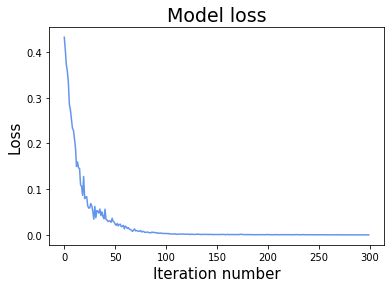

In [5]:
plot_loss(dg.loss, color='cornflowerblue')

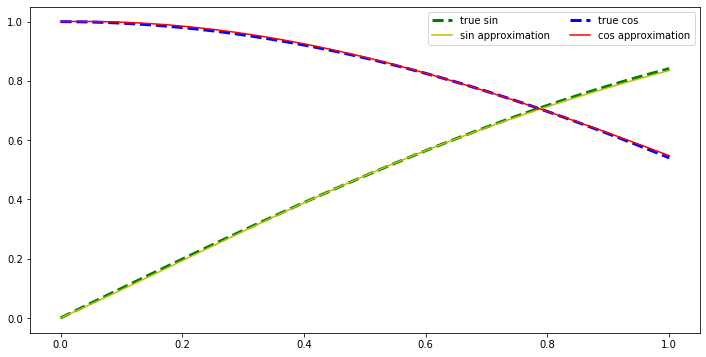

In [6]:
# Plot true solutions and their approximations
n_el = 100
pts = np.linspace(0, 1, n_el).reshape((n_el, 1))

true_sin = [np.sin(t) for t in pts]
true_cos = [np.cos(t) for t in pts]

approxs_sin = dg.solve(pts)[:, 0]
approxs_cos = dg.solve(pts)[:, 1]

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pts, true_sin, 'g--', linewidth=3, label='true sin')
plt.plot(pts, approxs_sin.reshape(n_el, ), 'y', label='sin approximation')
plt.plot(pts, true_cos, 'b--',  linewidth=3, label='true cos')
plt.plot(pts, approxs_cos.reshape(n_el, ), 'r', label='cos approximation')
plt.legend(ncol=2)
fig.show()

<a id='ex7'></a>

<a id='param'></a>
###  Parametric family of ODEs

It is not uncommon to see encounter an equation with parameters: some of them are taking values from a predefined domain, some of them draw values from various probabilistic disctributions. For example, one can have the need to solve such an equation:

$$
\frac{d f}{d t}= \varepsilon \cos[\varepsilon \pi t],
$$

$$
t \in [0, 1], f(0)=1, 
$$

$$
\varepsilon \in [1, 5].
$$

To work with such PDEs, we introduce letter `P`, that marks some coefficient as external parameter. Later, we can generate values for it either in determenistic or probabilistic ways by using appropriate `Sampler`.

In some sense, parameters are behaving in exactly the same way as regular coordinates like `time`, `x,y,z`: we must pass it as positional argument of `form` functions, it can be generated from the outside via `Sampler`.

In [7]:
pde = {
    'n_dims': 1,
    'form': lambda u, t, e: D(u, t) - P(e) * np.pi * cos(P(e) * np.pi * t),
    'initial_condition': 1
}

# put it together in model-config
config = {
    'pde': pde,
    'decay': {'name': 'invtime', 'learning_rate':0.01,
              'decay_steps': 100, 'decay_rate': 0.05},
    'track': {'dt': lambda u, t, e: D(u, t)}
}

# sampling scheme: one component for time and one for epsilon
s = NumpySampler('uniform') & NumpySampler('uniform', low=1, high=5)

In [8]:
# train the network on batches of 1000 points
dg = Solver(config)
dg.fit(batch_size=1000, sampler=s, n_iters=5000, bar='notebook')

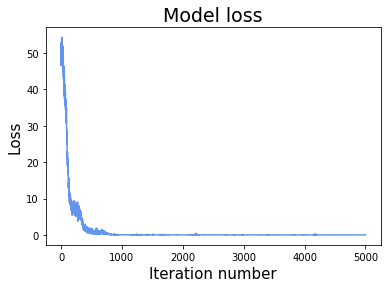

In [9]:
plot_loss(dg.loss, color='cornflowerblue')

In [10]:
from ipywidgets import interact

def plt_solution(e):
    # plot real solution and network approximation
    pts = np.concatenate([np.linspace(0, 1, 200).reshape(-1, 1), e * np.ones((200, 1))], axis=1)
    
    sol = lambda t: np.sin(e * np.pi * t) + 1
    true = sol(pts[:, 0])
    approxs = dg.solve(pts)
    
    plt.plot(pts[:, 0], true, 'b--', linewidth=3, label='True solution')
    plt.plot(pts[:, 0], approxs, 'r', label='Network approximation')
    plt.xlabel(r'$t$', fontdict={'fontsize': 14})
    plt.title(r'$\epsilon={}$'.format(e))
    plt.legend()
    plt.show()

In [11]:
_ = interact(plt_solution, e=(1, 5, 0.01))

interactive(children=(FloatSlider(value=3.0, description='e', max=5.0, min=1.0, step=0.01), Output()), _dom_cl…

<a id='adjust'></a>
## Equation with trainable coefficients

Generally speaking, usual PDE problem consists of multiple constraints imposed on unknown function: equation itself sets the dynamic, boundary and initial conditions restrict $u$ in their respective domains. It is natural to think of imposing even more constraints onto the function: this can be due to physics or visible observations, and can be used to make the solution of a particular problem unique.

On the other hand, if the solution to the problem is already unique, there is no reason to add more constraints: secondary restrictions are either compatible with already existing ones (and thus are redundant) or incompatible with them, disallowing our model to reduce loss-function to zero and making the task overly ambiguous.

Sometimes it makes sense to allow our model to slightly relax some of the existing constraints (namely, equation, initial/boundary conditions) in order to satisfy additional ones. For example, quite often in practical tasks, we know most of the coefficients from hand-made measurements. These are imperfect due to both equipment and human errors and can be improved with possible additional information about the solution: hypothetically, we can leverage this new info to adjust values of coefficients.

This brings us closely to the concept of inverse PDE problem. In most settings we are dealing with the direct problem of PDE solving: we know the equation and want to obtain the solution, while the inverse problem is to find the equation that will have the known function as its solution. From a standpoint of traditional PDE-solvers, these tasks are miles apart. However, from the perspective of **Galerkin** method (and our library in particular), there is virtually no difference between the two: we just optimize some error-functional with respect to some weights, and this is true for both direct and inverse problems of PDE solving: in the former case our weights represent unknown function, and in the latter we use these weights to adjust the equation itself.

As the previous example shows, real world is somewhere in-between those problems: we know a *lot* of information about the equation, but we also know enough information about the solution besides necessary boundary/initial conditions, and it is natural to use this abundance of data to make up for the uncertainty in the equation. 

Suppose we are working with 

$$
\frac{\partial u(t)}{\partial t} - u(t) = K\cos(Kt) e^t,
$$

$$
u(0) = 0.
$$

Suppose we know that solution is $1 + \sin(Kt)$ when $t \in [0.5, 0.8]$ range. We can

* track additional named tensor `expr` via `track` key of the config
* create multiple train steps
* alternate between training procedures during training of the approximator



In [12]:
# configuration of secondary neural network
block = {
    'layout': 'fa Rfa fa. fa f',
    'units': [15]*4 + [1],
    'activation': tf.nn.tanh
}

K = 5
pde = {
    'n_dims': 1,
    'form': lambda u, t: (D(u, t) *(1 + V(0.0, 'der'))
                          - u*(1 + V(0.0, 'fun'))
                          - K*cos(K*t)*exp(t) + C(u, t, 'rhs', **block)
                          ),
    'time_multiplier': 'polynomial',
    'initial_condition': 0.0,
    'bind_bc_ic': True
}


# put it together in model-config
config = {
    'pde': pde,
    'track': {'expr': lambda u, t: u - (1 + sin(K*t))},
    'decay': {'name': 'invtime', 'learning_rate':0.03,
              'decay_steps': 100, 'decay_rate': 0.15},
    'train_steps': {
        'network': {'scope': '-addendums'},
        'adds': {'scope': 'addendums'},
        'ac': {'scope': '-addendums',
                   'loss':{'name': 'mse', 'predictions':'expr'}},
    },
    'optimizer': 'RMSProp',
}

# uniform sampling scheme
s = NumpySampler('uniform')
s_c = NumpySampler('uniform', low=0.5, high=0.8)# ConstantSampler(0.5)

In [13]:
# train the network on batches of 100 points
dg = Solver(config)

iters = [10, 5, 5] * 5

for _ in tqdm_notebook(range(500)):
    _ = dg.fit(batch_size=100, sampler=s, n_iters=iters[0], fetches='loss_network', train_mode='network')
    
    _ = dg.fit(batch_size=100, sampler=s_c, n_iters=iters[1], fetches='loss_ac', train_mode='ac')

    _ = dg.fit(batch_size=100, sampler=s, n_iters=iters[2], fetches='loss_adds', train_mode='adds')

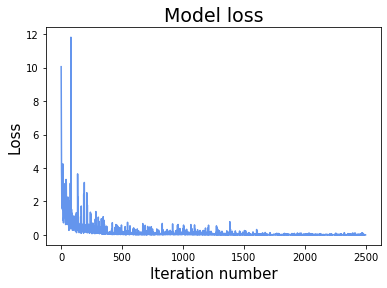

In [14]:
plot_loss(dg.loss_adds, color='cornflowerblue')

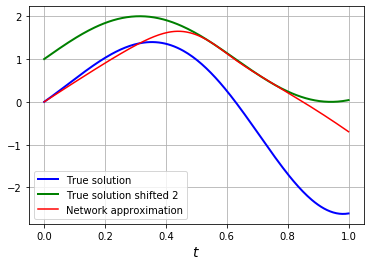

In [15]:
# plot real solution and network approximation
pts = np.linspace(0, 1, 200).reshape(-1, 1)

sol = lambda t: np.sin(K*t)*np.exp(t) + 0
sol_2 = lambda t: 1 + np.sin(K*t) #np.sin(K*t)*np.exp(t) + 2
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b', linewidth=2, label='True solution')

shifted = [sol_2(t[0]) for t in pts]
plt.plot(pts, shifted, 'g', linewidth=2, label='True solution shifted 2')

approxs = dg.solve(pts)
plt.plot(pts, approxs, 'r', label='Network approximation')

plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.grid(True)
plt.show()

In [16]:
dg.solve(fetches='fun')

1.113616

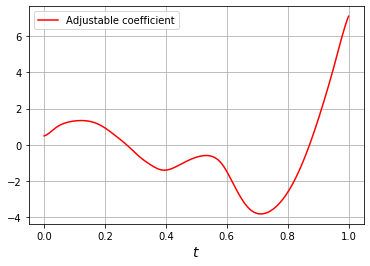

In [17]:
# plot real solution and network approximation
pts = np.linspace(0, 1, 200).reshape(-1, 1)

approxs = dg.solve(pts, fetches='rhs')

plt.plot(pts, approxs, 'r', label='Adjustable coefficient')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.grid(True)
plt.show()